In [1]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import seaborn as sns
import pandas as pd
import numpy as np
import PIL
import glob
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [40]:
#print(plt.style.available)
plt.style.use('ggplot')

In [215]:
df = pd.read_csv('data/votos_senado.csv')

In [216]:
df.head(2)

,candidato_id,candidato_name,candidato_part,candidato_uf,date,proposition_id,proposition_name,sessao_desc,sessao_id,voto
0,1023,Maria do Carmo do Nascimento Alves,DEM,SE,2012-04-25 00:00:00,103817,OFS 61/2011,21259,67,0
1,70,José Renan Vasconcelos Calheiros,MDB,AL,2012-04-25 00:00:00,103817,OFS 61/2011,21259,67,0


In [217]:
df.groupby(['proposition_name'])['sessao_desc'].apply(lambda x: x.unique().shape[0]).value_counts()

1    784
2     45
3      2
Name: sessao_desc, dtype: int64

In [218]:
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df['ano'] = df['date'].apply(lambda x:x.year)

In [219]:
df.columns

Index(['candidato_id', 'candidato_name', 'candidato_part', 'candidato_uf',
       'date', 'proposition_id', 'proposition_name', 'sessao_desc',
       'sessao_id', 'voto', 'ano'],
      dtype='object')

In [220]:
df.loc[df['candidato_part'] == 'S/Partido', 'candidato_part'] = 'S.PART.'
df['candidato_part'].fillna('S.PART.', inplace=True)
df['candidato_uf'].fillna('', inplace=True)

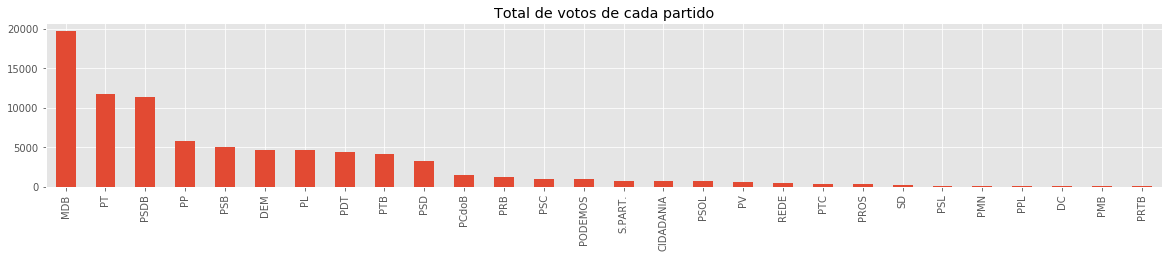

In [221]:
plt.figure(figsize=(20,3))
df['candidato_part'].value_counts().plot(kind="bar")
plt.title('Total de votos de cada partido')
plt.show();

In [222]:
maiores_partidos = (df['candidato_part'].value_counts() > 1000)
maiores_partidos = ['OUTROS'] + maiores_partidos[maiores_partidos].index.tolist()
df.loc[~df['candidato_part'].isin(maiores_partidos), 'candidato_part'] = 'OUTROS'

In [223]:
ct = pd.crosstab(df['ano'], df['candidato_part'])
ct = ct.reindex(columns=maiores_partidos)

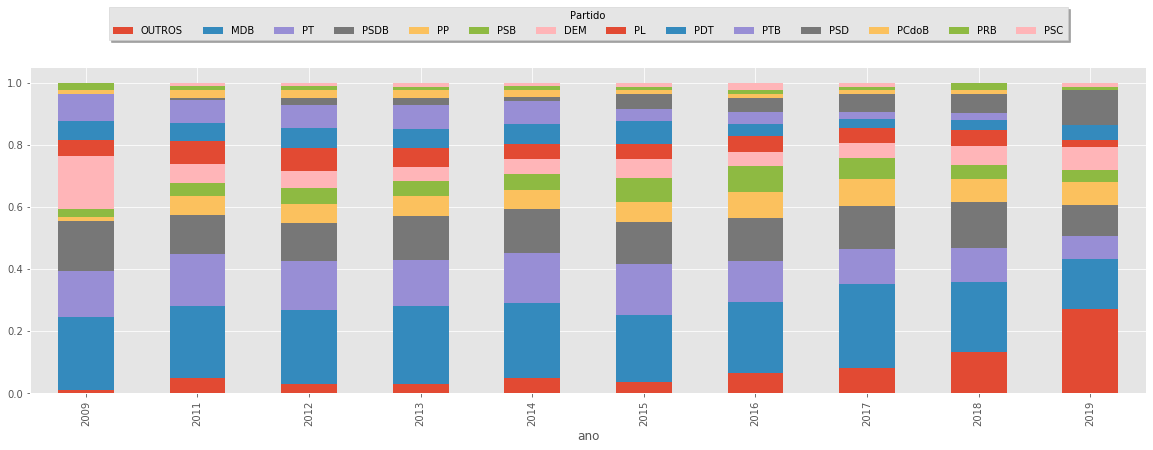

In [151]:
fig, ax = plt.subplots(figsize=(20,6))

ct.div(ct.sum(axis=1), axis=0).plot.bar(stacked=True, ax=ax)
ax.legend(title='Partido', loc='upper center', bbox_to_anchor=(0.5, 1.20),
          ncol=14, fancybox=False, shadow=True)
plt.show()

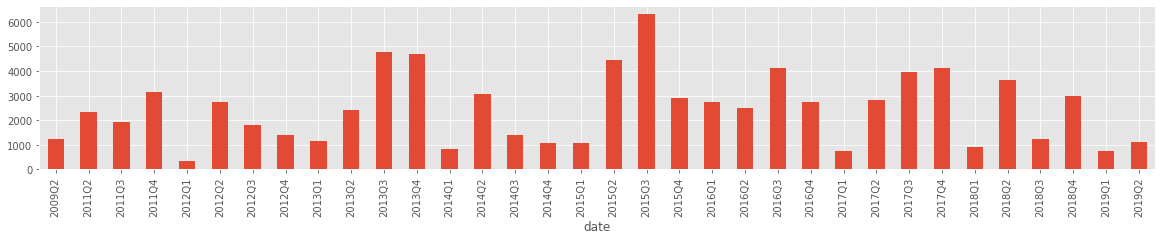

In [152]:
plt.figure(figsize=(20,3))
df.groupby(df['date'].dt.to_period('Q'))['voto'].count().plot(kind='bar')

In [293]:
v = pd.pivot_table(df, values='voto', index=['candidato_id', 'candidato_part'], columns='proposition_id', fill_value=0)

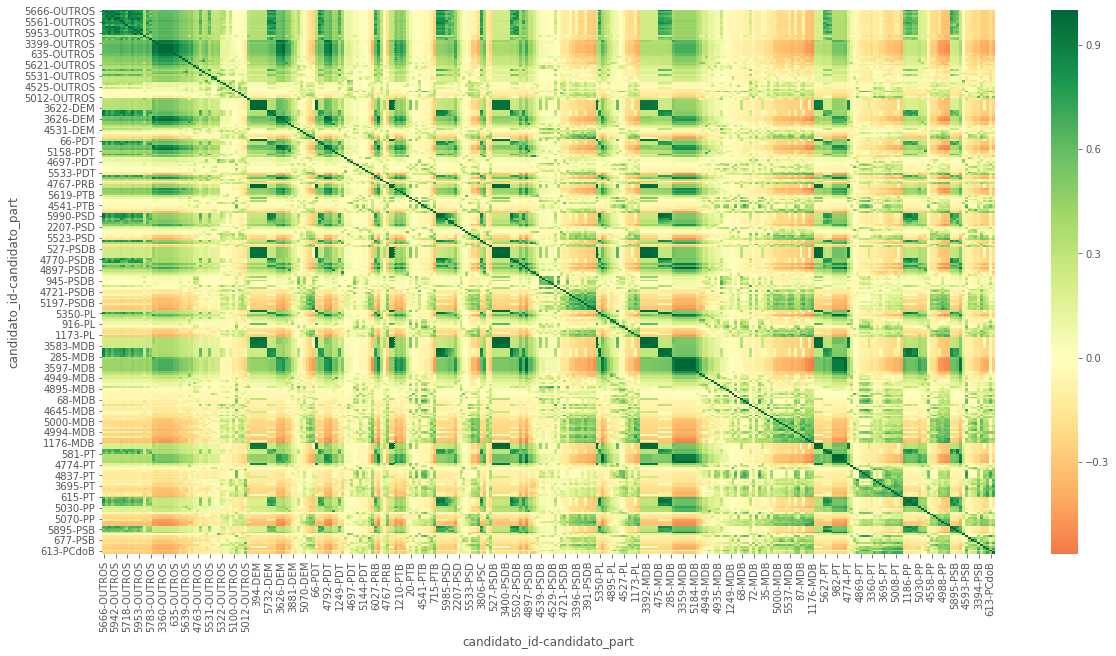

In [225]:
v['x'] = PCA(1).fit_transform(v)
x_part = v.groupby('candidato_part')['x'].mean()
v = v.merge(x_part, how='inner', left_on='candidato_part', right_index=True, suffixes=['', '_part'])
plt.figure(figsize=(20,10))
v = v.sort_values(['x_part', 'x'])
sns.heatmap(v.T.corr(), cmap='RdYlGn', center=0)
v.drop(['x_part', 'x'], axis=1, inplace=True)
plt.show()

In [205]:
part = v.reset_index().drop('candidato_id', axis=1).groupby('candidato_part').mean()

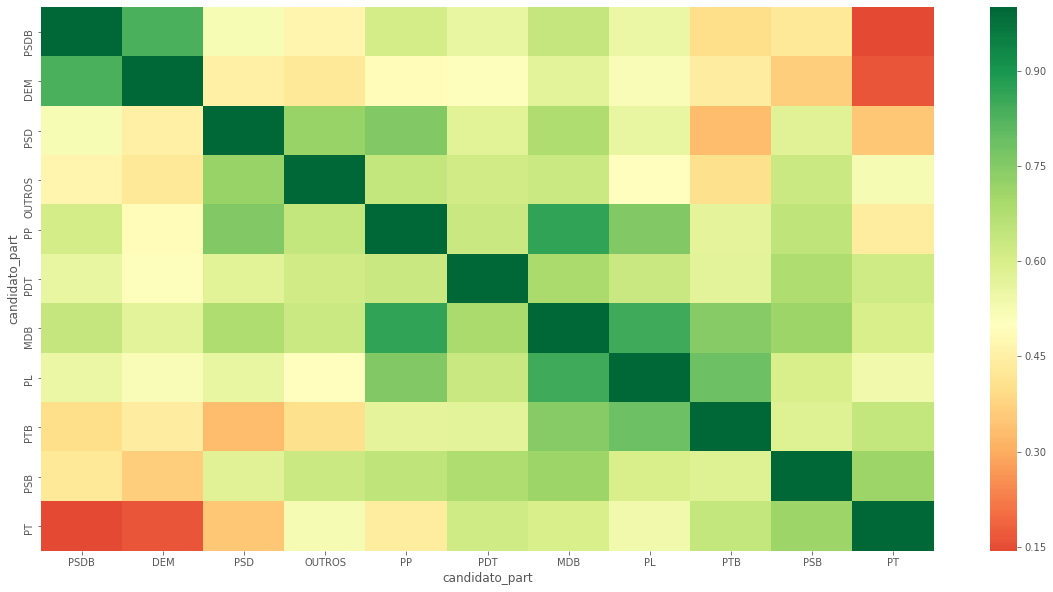

In [199]:
part['x'] = PCA(1).fit_transform(part)
part = part.sort_values('x')
part.drop('x', axis=1, inplace=True)

plt.figure(figsize=(20,10))
sns.heatmap(part.T.corr(), cmap='RdYlGn', center=0.5)
plt.show()

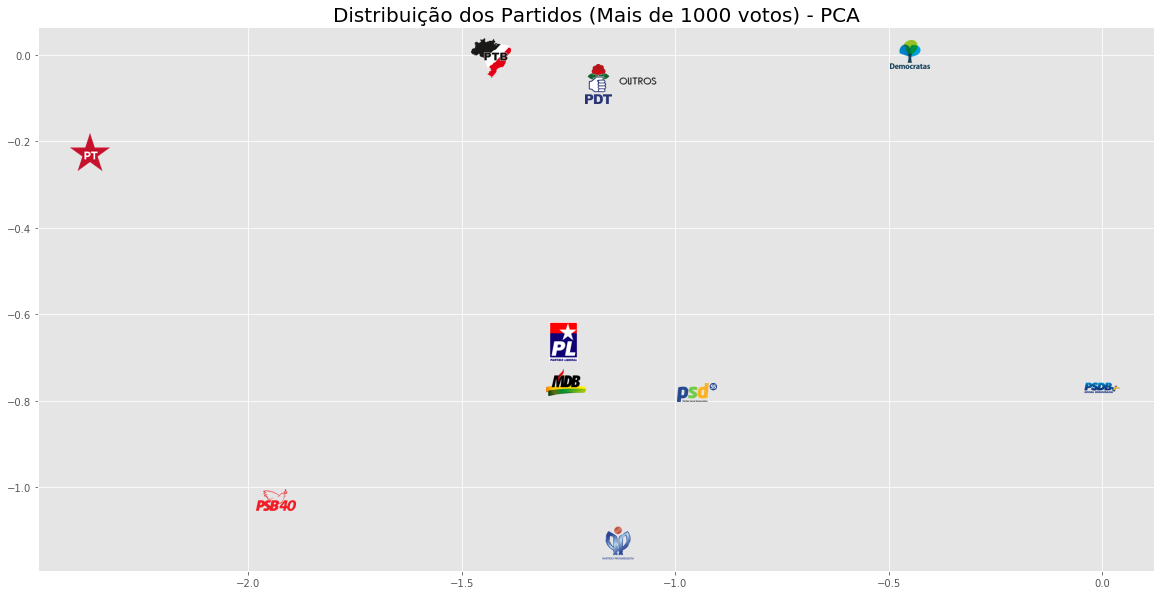

In [200]:
x, y = PCA(2).fit_transform(part).T
x, _ = boxcox(x + abs(x.min()) + 1)
y, _ = boxcox(y + abs(y.min()) + 1)

def getImage(partido, size=40):
    p = partido.upper().replace(' ', '')
    path = glob.glob(f"../logos/{p}.*")[0]
    img = PIL.Image.open(path)
    img.thumbnail((size, size))
    return OffsetImage(img)

fig, ax = plt.subplots(figsize=(20, 10))
with plt.style.context(('default')):
    sns.scatterplot(-x, -y, hue=part.index, legend=False, alpha=0)
for x0, y0, path in zip(x, y, part.index.tolist()):
    ab = AnnotationBbox(getImage(path), (-x0, -y0), frameon=False)
    ax.add_artist(ab)
#plt.xticks([], [])
#plt.yticks([], [])
plt.title('Distribuição dos Partidos (Mais de 1000 votos) - PCA', size=20)
plt.show()

In [201]:
diff = part.loc[['PP', 'PDT']].T
diff['abs'] = (diff['PP'] - diff['PDT']).abs()
diff.sort_values('abs', ascending=False).head(4)

candidato_part,PP,PDT,abs
127863,0.4375,0.0,0.4375
127644,0.4375,0.0,0.4375
129378,0.4375,0.0,0.4375
129619,0.4375,0.0,0.4375


In [202]:
df.groupby('candidato_part')['voto'].sum().sort_values()

candidato_part
PSD        690
PTB        737
DEM        783
PDT        790
PL         952
PSB       1104
PP        1203
OUTROS    1672
PSDB      2245
PT        2255
MDB       3695
Name: voto, dtype: int64

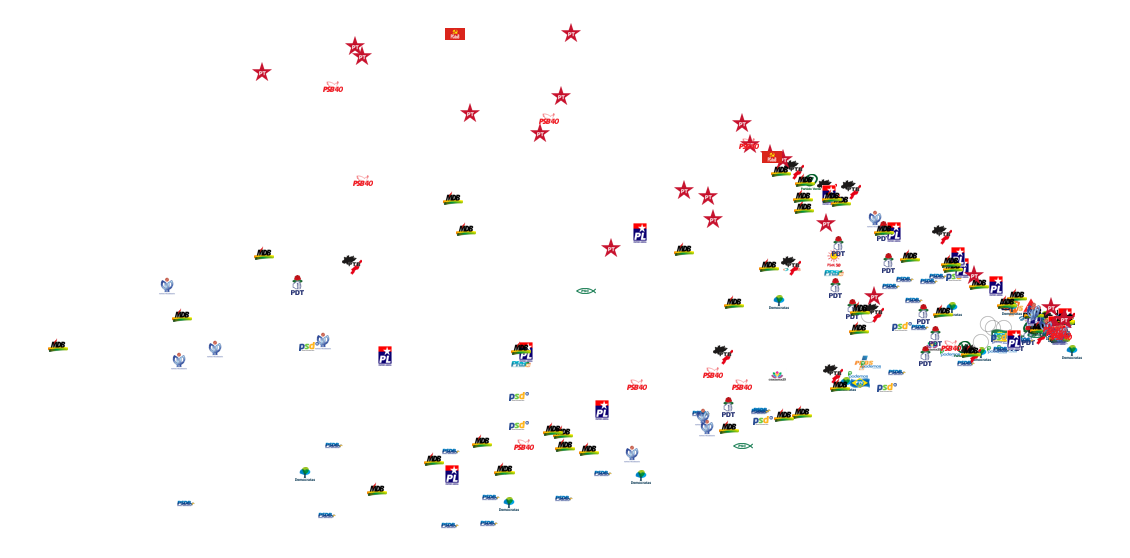

In [167]:
x, y = PCA(2).fit_transform(v).T

partido = v.index.get_level_values('candidato_part')

fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(-x, y, legend=False, alpha=0)
for x0, y0, path in tqdm(zip(x, y, partido), total=x.shape[0]):
    ab = AnnotationBbox(getImage(path, 20), (-x0, y0), frameon=False)
    ax.add_artist(ab)
plt.axis('off')
plt.show()

In [294]:
v = v.reset_index().set_index('candidato_id')

In [227]:
v['candidato_part'].unique()

array(['OUTROS', 'DEM', 'PDT', 'PRB', 'PTB', 'PSD', 'PSC', 'PSDB', 'PL',
       'MDB', 'PT', 'PP', 'PSB', 'PCdoB'], dtype=object)

In [242]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
results = cross_val_score(svc, v.drop('candidato_part', axis=1), v['candidato_part'], cv=5)
results

/Users/willian/notebooks_env/brazilian-political-compass/env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


array([0.078125  , 0.11290323, 0.2295082 , 0.37288136, 0.39285714])

In [290]:
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree

xgb = XGBClassifier()
#results = cross_val_score(xgb, v.drop('candidato_part', axis=1), v['candidato_part'], cv=5)
#results

In [292]:
v.columns

Index(['candidato_part',              nan,              nan,              nan,
                    nan,              nan,              nan,              nan,
                    nan,              nan,
       ...
                    nan,              nan,              nan,              nan,
                    nan,              nan,              nan,              nan,
                    nan,              nan],
      dtype='object', length=832)

In [306]:
v.rename(lambda x: 'proj_'+str(x), inplace=True, axis=1)

In [308]:
#v.columns.str.replace(" ", "_")

xgb.fit(v.drop('proj_candidato_part', axis=1), v['proj_candidato_part'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [296]:
from sklearn.metrics import confusion_matrix
labels = v['candidato_part'].unique()
confusion_matrix = confusion_matrix(v['candidato_part'], xgb.predict(v.drop('candidato_part', axis=1)), labels=labels)
confusion_matrix = pd.DataFrame(confusion_matrix, index=labels, columns=labels)

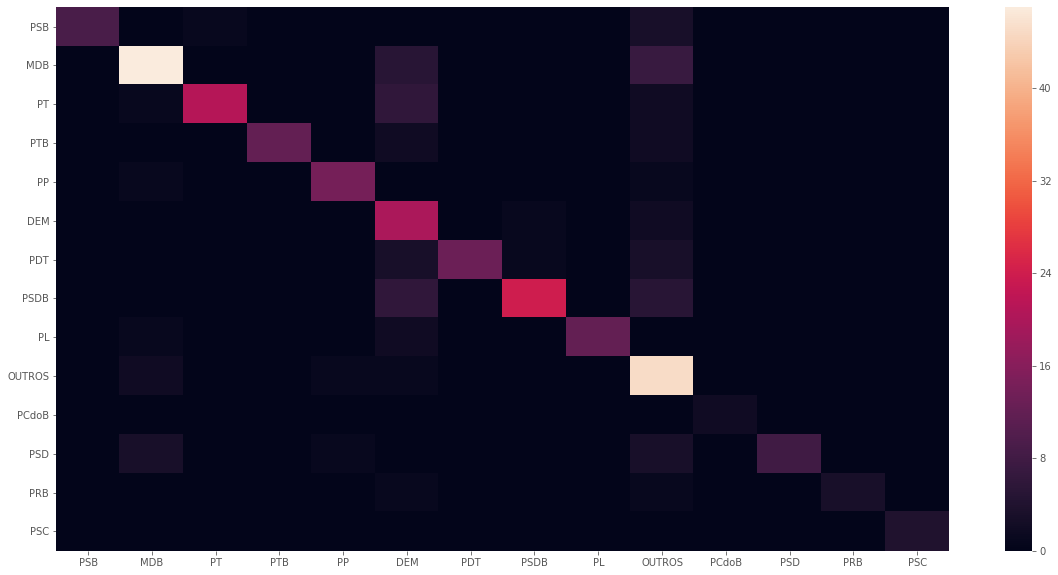

In [297]:
plt.figure(figsize=(20, 10))
sns.heatmap(confusion_matrix)

In [264]:
importance = pd.DataFrame(data=xgb.feature_importances_, index=v.drop('candidato_part', axis=1).columns)

In [271]:
propositions = df[['proposition_id', 'proposition_name']]
propositions = propositions[~propositions.duplicated()].set_index('proposition_id')

In [275]:
importance = pd.merge(importance, propositions, how='left', left_index=True, right_index=True).sort_values(by=0, ascending=False)

In [284]:
importance.head()

,0,proposition_name
113049,0.022661,PLV 15/2013
120159,0.022117,SCD 5/2015
123466,0.021327,MPV 695/2015
123467,0.016346,MPV 696/2015
104943,0.013992,PLV 7/2012


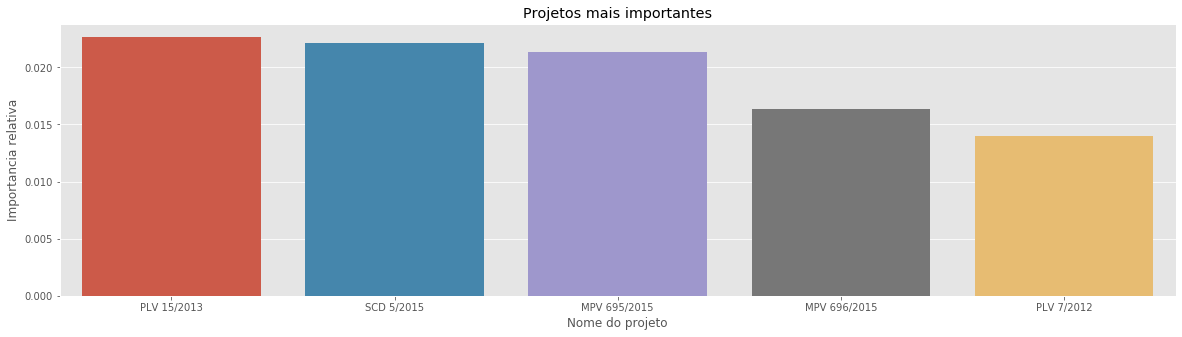

In [283]:
plt.figure(figsize=(20,5))
sns.barplot(x=importance.head()['proposition_name'], y=importance.head()[0])
plt.title('Projetos mais importantes')
plt.ylabel('Importancia relativa')
plt.xlabel('Nome do projeto');

In [309]:
v.columns

Index(['proj_candidato_part', 'proj_56281', 'proj_60148', 'proj_72589',
       'proj_80152', 'proj_80384', 'proj_80674', 'proj_82419', 'proj_83009',
       'proj_83840',
       ...
       'proj_135079', 'proj_135087', 'proj_135088', 'proj_135250',
       'proj_135251', 'proj_135252', 'proj_135603', 'proj_135983',
       'proj_136173', 'proj_136357'],
      dtype='object', name='proposition_id', length=832)

AttributeError: 'XGBClassifier' object has no attribute 'to_graphviz'

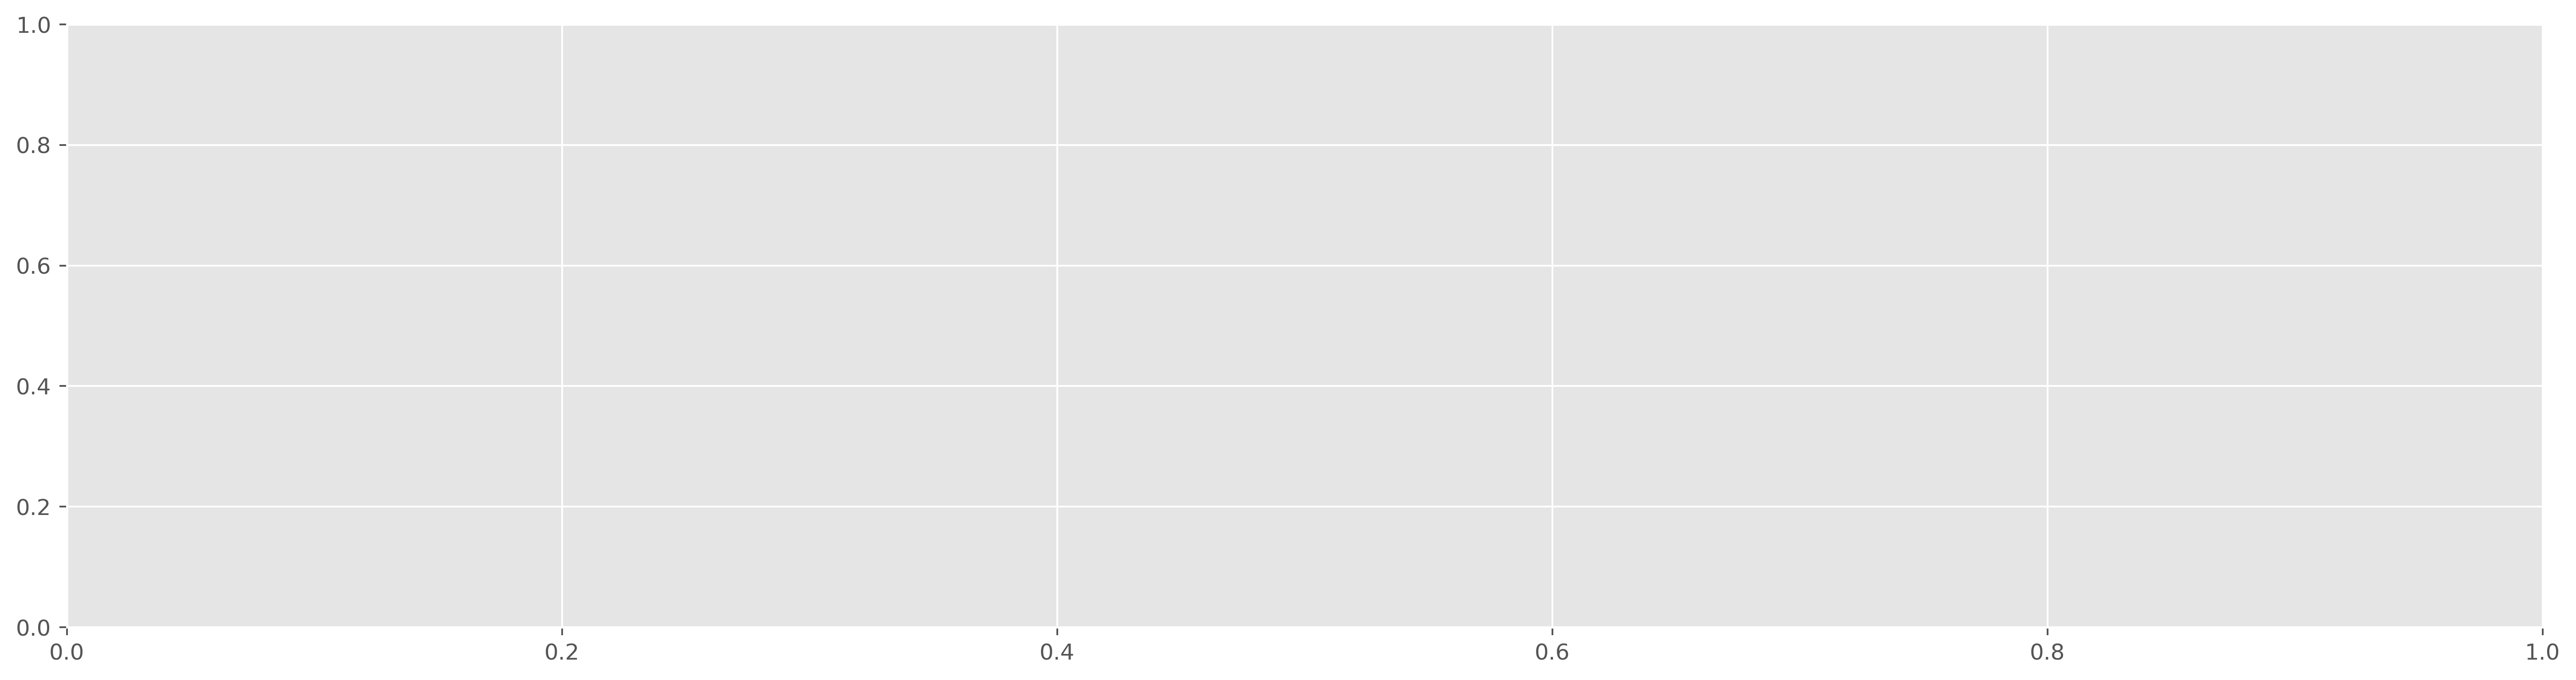

In [319]:
fig = plt.figure(dpi=360, figsize=(20, 5))
ax = plt.subplot(1,1,1)
plt
xgb.to_graphviz(num_trees=0, rankdir='LR', ax=ax)
plt.show()